# K Means Clustering

## Import Libraries

** Import the libraries you usually use for data analysis.**

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Get the Data

** Read in the College_Data file using read_csv. Figure out how to set the first column as the index.**

In [26]:
df = pd.read_csv('./clean_data/adult_train.txt',index_col=False)

## K Means Cluster Creation

** Import KMeans from SciKit Learn.**

In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report

In [28]:
kmeans = KMeans(n_clusters=2, random_state=111)
kmeans.fit(df.drop('income',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [29]:
print(confusion_matrix(df['income'],kmeans.labels_))
print(classification_report(df['income'],kmeans.labels_))

[[13957  8697]
 [ 2343  5165]]
             precision    recall  f1-score   support

          0       0.86      0.62      0.72     22654
          1       0.37      0.69      0.48      7508

avg / total       0.74      0.63      0.66     30162



In [45]:
# standardize only continuous nymeric columns
a = df[['age','hr_per_week']]
df[['age','hr_per_week']] = (a-a.mean()) / np.std(a)

**Let's normalize the Data and apply clustering**

In [72]:
df_norm = df.drop('income',axis=1)
kmeans.fit(df_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [73]:
print(confusion_matrix(df['income'],kmeans.labels_))
print(classification_report(df['income'],kmeans.labels_))

[[13703  8951]
 [ 1030  6478]]
             precision    recall  f1-score   support

          0       0.93      0.60      0.73     22654
          1       0.42      0.86      0.56      7508

avg / total       0.80      0.67      0.69     30162



### Apply PCA to Normalized Data 

In [74]:
#from sklearn.decomposition import PCA

In [75]:
#from mpl_toolkits.mplot3d import Axes3D

In [76]:
#pca = PCA(n_components=3)
#pca.fit(df_norm)
#pca3 = pca.transform(df_norm)

In [112]:
#fig = plt.figure(figsize=(7,5))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pca3[:,0], pca3[:,1],pca3[:,2],c=df['income'],cmap='plasma')

In [113]:
#d = {'pca1': pca3[:,0], 'pca2': pca3[:,1], 'pca3': pca3[:,2]}
#df_pca3 = pd.DataFrame(d)


In [114]:
#kmeans.fit(df_pca3)

In [115]:
#print(confusion_matrix(df['income'],kmeans.labels_))
#print(classification_report(df['income'],kmeans.labels_))

## Try it on whole data

In [116]:
pca_all = PCA(n_components=65)
pca_all.fit(df_norm)
pca_n = pca_all.transform(df_norm)

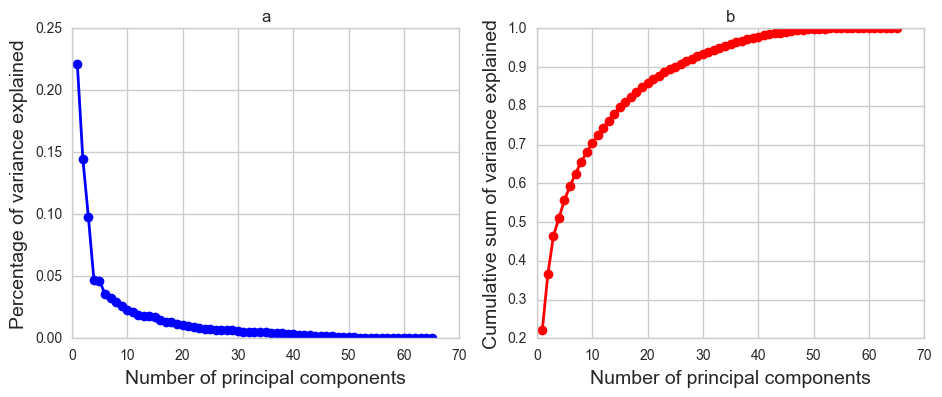

In [117]:
y = pca_all.explained_variance_ratio_
x = np.arange(len(y)) + 1

fig = plt.figure(figsize=(11,4))
sub1 = plt.subplot(121, title = 'a')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Percentage of variance explained', fontsize = 14)
plt.plot(x ,y, '-o',lw=2., color='blue')

sub2 = plt.subplot(122, title = 'b')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Cumulative sum of variance explained', fontsize = 14)
plt.plot(x ,np.cumsum(y), '-o',lw=2.0, color='red')

In [118]:
kmeans.fit(pca_n)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [119]:
print(confusion_matrix(df['income'],kmeans.labels_))
print(classification_report(df['income'],kmeans.labels_))

[[13703  8951]
 [ 1030  6478]]
             precision    recall  f1-score   support

          0       0.93      0.60      0.73     22654
          1       0.42      0.86      0.56      7508

avg / total       0.80      0.67      0.69     30162



In [120]:
pca_all = PCA(n_components=0.99,  svd_solver = 'full')
#pca_all.fit(df_norm)
pca_all.fit(df.drop('income',axis=1))
pca_n = pca_all.transform(df_norm)
pca_all.n_components_


45